# Manuscripts


We scrape the following two websites to get the manuscripts

- [imsdb](http://www.imsdb.com/)
- [springfieldspringfield](https://www.springfieldspringfield.co.uk/)
- [imsdb movie scripts](https://figshare.com/projects/imsdb_movie_scripts/18907)


In [545]:
# lets start by getting the data
import csv
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import json
import re
import os
import matplotlib.pyplot as plt
import matplotlib as mpl 
import operator
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
import operator
from math import log10, floor
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Function used to round numbers to n significant numbers
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [422]:
movies_to_delete =[
    'National Lampoon’s Van Wilder',
    'Bran Nue Dae',
    'Pokémon: Spell of the Unknown',
    'Alien³',
    'Guten Tag, Ramón'
]

In [423]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary

filepath = "/Users/GretarAtli/Documents/GitHub/Dtu/Dtu-SocialGraphs-FinalProject/Data/tmdb-5000-movie-dataset/tmdb_5000_credits.csv"
tmdb_5000_credits = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_credits[row["title"]] = row
        tmdb_5000_credits[row["title"]]['cast'] = json.loads(tmdb_5000_credits[row["title"]]['cast'])
        tmdb_5000_credits[row["title"]]['crew'] = json.loads(tmdb_5000_credits[row["title"]]['crew'])

In [424]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary

filepath = "/Users/GretarAtli/Documents/GitHub/Dtu/Dtu-SocialGraphs-FinalProject/Data/tmdb-5000-movie-dataset/tmdb_5000_movies.csv"
tmdb_5000_movies = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_movies[row["title"]] = row
        # put the lists and dictonaries to a correct format, (that is not as string)
        tmdb_5000_movies[row["title"]]['genres'] = json.loads(tmdb_5000_movies[row["title"]]['genres'])
        tmdb_5000_movies[row["title"]]['keywords'] = json.loads(tmdb_5000_movies[row["title"]]['keywords'])
        tmdb_5000_movies[row["title"]]['production_companies'] = json.loads(tmdb_5000_movies[row["title"]]['production_companies'])
        
for title in sorted(tmdb_5000_movies.keys()):
    title = title.replace(" ","-").replace("(","").replace(")","")

Delete movies that we decited to not include in our analysis. This was done because these movies do not have imdb score or there where some information lacking in the kaggle database for these movies

In [425]:
for movie in movies_to_delete:
    del tmdb_5000_credits[movie]
    del tmdb_5000_movies[movie]

## Get scripts from .txt files 


Fetching the scripts from the hard drive and check if the corresponding movie is a part of our main database. We want to find the size of the intersection to our database. In other words the number of scripts that correspond to a movie in our taggle database

In [426]:
filepath_scripts =  "/Users/GretarAtli/Dropbox/SocialGraph/scripts/"


# A python dictionary that maintains the information what movie has a manuscript in our database
manuscripts = defaultdict(bool)

for title in sorted(tmdb_5000_credits.keys()):
    title_for_uri = title.replace(" ","-").replace("(","").replace(")","")
    filename = filepath_scripts + title_for_uri + ".txt"
    try:
        #print (filename)
        f = open(filename,"r")
        manuscripts[title] = True
    except:
        manuscripts[title] = False

## Check intersection

We only want to make analysis on the movies that are part of the kaggle database. Therefore we start by finding the intersection between the scripts database and the kaggle database. In other words we want to find the movies that are part of both databases.

In [427]:
manuscripts_intersection = [key for key,value in manuscripts.items() if value == True]

In [428]:
print("Number of movies that are in both databases is: {} movies".format(len(manuscripts_intersection)))

Number of movies that are in both databases is: 686 movies


## Time span manuscripts

In [429]:
movies_with_manuscripts = [(key, tmdb_5000_movies[key]["release_date"].split("-")[0] ) 
                           for key,value in manuscripts.items() if value == True]

mwm_year_dist = Counter([year for _,year in movies_with_manuscripts])

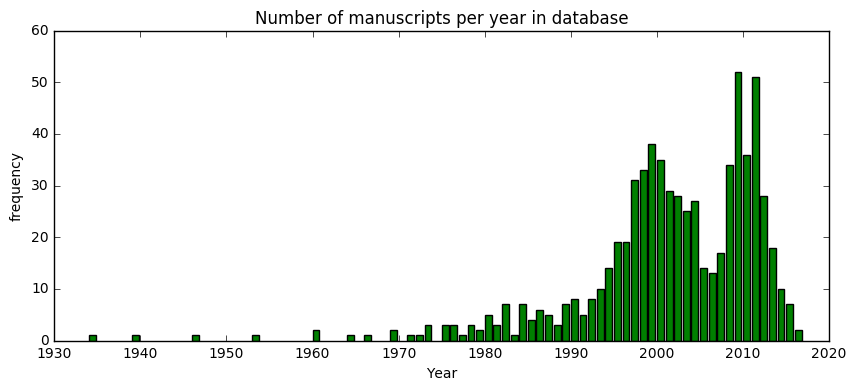

In [430]:
plt.figure(figsize=(10,4))
plt.bar(mwm_year_dist.keys(), mwm_year_dist.values(), color="green")
plt.xlabel("Year")
plt.ylabel("frequency")
plt.title("Number of manuscripts per year in database")
plt.show()

It can be seen here above that most of the manuscripts are from the period 1990 util 2015. 

# Sentiment Analysis

Now we have the scripts ready to do our sentiment analysis of the manuscripts. The first thing that is done is to get the happyness rank from the LabMT wordlist.  It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1).

We start of by getting the average happiness of each word in Data set S1 into a dictionary. We do this by reading dat set line by line and for each line (exept the first 4 lines) into a dictionary

The dataset as well as more information about how the average happyness value of each word in the dataset is calculated can be found by clicking on the following [link](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s2)

In [431]:
from collections import defaultdict

# counter to count the number of lines that have been processed
counter = 0

happyness_rank = defaultdict(float)
path = '/Users/GretarAtli/Documents/GitHub/Dtu/Dtu-SocialGraphs-FinalProject/Data/Data_Set_S1.txt'
with open(path) as f:
    for line in f:
        counter += 1
        
        # we want to skip the first 4 lines of the file
        if counter > 4:
            line = line.split()
            word = line[0]  # get the word from the line
            happiness_average = float(line[2]) # get the word happiness average
            happyness_rank[word] = happiness_average

In [432]:
import numpy as np

from __future__ import division

# Takes in a list of tokens and the happiness_keys which is the list of words in data set 1
# returns the mean value of the happiness rank that was found in the tokens array
# if no value was found then the function returns None
def estimateHappiness(tokens,happiness_keys):
    
    happiness_avg = [] # an array that contains the average happyness values of the tokens
    
    for token in tokens:
        # only include the words that can be found in the data set
        if token in happiness_keys: 
            happiness_avg.append(happyness_rank[token])
            
    # If no word in the tokens array is found in the dataset then we return 0
    if len(happiness_avg) == 0:
        return None
    else : 
        return np.mean(happiness_avg)

In [433]:
filepath_scripts =  "/Users/GretarAtli/Dropbox/SocialGraph/scripts/"


happiness_keys = set(happyness_rank.keys())

# Create a dictionary that is a container for the sensitivity analysis values
happiness_score = defaultdict(float)


counter = 0
for title in manuscripts_intersection:
    title_for_uri = title.replace(" ","-").replace("(","").replace(")","")
    filename = filepath_scripts + title_for_uri + ".txt"
    #print (filename)
    f = open(filename,"r")
    
    movie_text_tokens = []
    
    for line in f.readlines():
        # Clean the text by eliminating punctations 
        translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        line = line.translate(translator)
        
        # We decided to eliminate sentances if it only contains upper case letters. 
        # because we did not want to include the scene headings
        if not line.isupper():
            line = line.lower() # make the whole line lower case
            line = line.split()
            # filter out the stop words 
            if line:
                #print (line)
                for word in line:
                    movie_text_tokens.append(word)
    
    happiness_score[title] = estimateHappiness(movie_text_tokens,happiness_keys)
    #break
    counter += 1
    #print(counter)

** Save the result to a file**

In [434]:
result_file_uri = "/Users/GretarAtli/Dropbox/SocialGraph/results/happiness-score.json"

with open(result_file_uri, 'w') as fp:
    json.dump(happiness_score, fp)


## Pre Analysing the result

We start our analysis by plotting um the average sentiment score for all of the 686 movie scripts that we are going to analyse

In [435]:
y, x = np.histogram(list(happiness_score.values()),100)

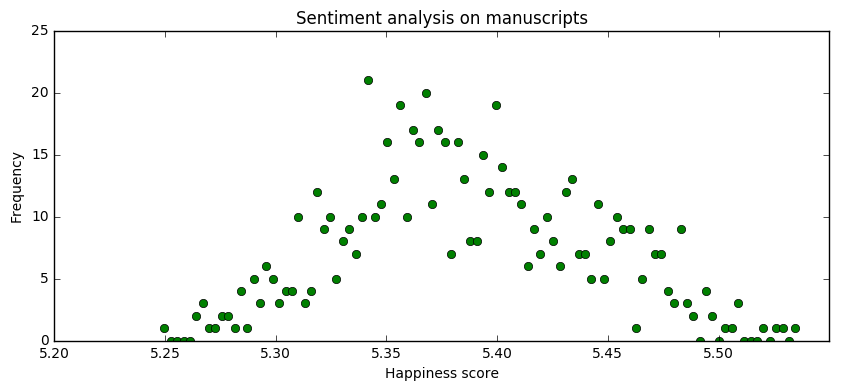

In [436]:
plt.figure(figsize=(10,4))
plt.plot(x[0:-1], y, 'o', color="green",)
plt.title("Sentiment analysis on manuscripts")
plt.ylabel("Frequency")
plt.xlabel("Happiness score")
plt.show()

- It can be seen that the average sentiment or happyness score of the movies forms a distribution that looks a lot like normal distribution. The values are all within quite narrow range, which is understandable because we are calculating the average sentiment of the movies over a whole manuscript. Therefore the values will all be dragged towards the average happyness score of the LabMT wordlist. However, the results still has some variance and we will analyse the difference further here down below. 
- It is interesting to see that the distribution seems to be inline with the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). 
- We decided to not delete the stopwords from the token list of each manuscript, the reason being that the LabMT wordlist contains stopwords and therefore, in our opinion, it does not make sens to excluse the informtion that the stopwords contain. 

**The ten 'happiest scripts' are : **

It is interesting to see what are the 10 movies that have the happiest vocabulary on average.

In [437]:
ten_happiest = sorted(happiness_score.items(), key=operator.itemgetter(1), reverse=True)[0:10]

print ("{movie_s: <35} {sentimentscore_s: <16} {genre_s: <14} ".format(
    movie_s = "Movie", sentimentscore_s = "Avg. score", genre_s = "Genres"))

print ("---------------------------------------------------------------------------------")

for key,value in ten_happiest:      
    # Create the genre string 
    genres = ""
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genres = genres + genre + " "
    
    print ("{movie_s: <35} {sentimentscore_s: <16}  {genre_s: <14}".format(
            movie_s =  key, 
            sentimentscore_s = round_sig(value,5),
            genre_s = genres
        ))


Movie                               Avg. score       Genres         
---------------------------------------------------------------------------------
Mary Poppins                        5.5375            Comedy Family Fantasy 
Boyhood                             5.5303            Drama         
Bridesmaids                         5.5273            Comedy Romance 
Her                                 5.5222            Romance Science Fiction Drama 
The Family Man                      5.5103            Comedy Drama Romance Fantasy 
Napoleon Dynamite                   5.5102            Comedy        
Precious                            5.5094            Drama         
The Perks of Being a Wallflower     5.5082            Drama Romance 
Rachel Getting Married              5.5039            Drama         
It's Complicated                    5.4989            Comedy Romance 


The result is not surprising and quite understandable. It can be seen that the movies with the highest average sentiment score are all so called "feel good movies" that we would in forehand expect to have quite happy vocabulary. This is something that we expected and it is nice to see that the result is in line with our intuition.

**The ten 'unhappiest scripts are:'**

It is also interesting to see what are the 10 movies that have the "unhappiest" vocabulary on average.

In [438]:
ten_unhappiest = sorted(happiness_score.items(), key=operator.itemgetter(1), reverse=False)[0:10]

print ("{movie_s: <35} {sentimentscore_s: <16} {genre_s: <14} ".format(
    movie_s = "Movie", sentimentscore_s = "Avg. score", genre_s = "Genres"))

print ("---------------------------------------------------------------------------------")

for key,value in ten_unhappiest:      
    # Create the genre string 
    genres = ""
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genres = genres + genre + " "
    
    print ("{movie_s: <35} {sentimentscore_s: <16}  {genre_s: <14}".format(
            movie_s =  key, 
            sentimentscore_s = round_sig(value,5),
            genre_s = genres
        ))

Movie                               Avg. score       Genres         
---------------------------------------------------------------------------------
Army of Darkness                    5.2498            Fantasy Horror Comedy 
Blade II                            5.265             Fantasy Horror Action Thriller 
Dawn of the Dead                    5.2655            Fantasy Horror Action 
Resident Evil                       5.268             Horror Action Science Fiction 
Predator                            5.2687            Science Fiction Action Adventure Thriller 
Cliffhanger                         5.269             Action Adventure Thriller 
Day of the Dead                     5.2699            Horror Science Fiction 
Alone in the Dark                   5.2748            Action Fantasy Horror Thriller 
The Thing                           5.2767            Horror Mystery Science Fiction 
Conan the Barbarian                 5.2769            Adventure Fantasy Action 


Again the result is as expected. The movies with the 'unhappiest' manuscript vocabulary are all movies that we could easily expect to have a negative vocabulary. These are all action or horror movies where the main storyline of the movie evolves around death or war. 

## Sentiment Vs Success of a movie 

To further analyse the sentiment, we wanted to find out if the sentiment has something to do with the success of the movie. We defined the success of both as the total revenue earn by the movie and also the movie imdb score. To investigate this we simply investigated if there was any correlation between first sentiment of each movie versus the imdb score of the movie and secondly if there we a correlation between the sentiment and the total revenue earn by the movie. 

** First we get the IMDB Rating for each movie **

In [439]:
# We use the fact that we know that each movie has a name, so we do not include any error handling
def findMovieNameFromId(id):
    name = [key for key,info in tmdb_5000_movies.items() if info['id'] == id]
    return name[0]

In [440]:
result_file_uri = "/Users/GretarAtli/Dropbox/SocialGraph/results/imdb-score-mod.json"

# Getting Imdb scores from data and convert the id to name 
json1_file = open(result_file_uri)
json1_str = json1_file.read()
Imdb_5000_movies_withid = json.loads(json1_str)

Imdb_5000_movies = defaultdict(float)

# change the dictionary key from id to name of the movie
for key,value in Imdb_5000_movies_withid.items():
    try:
        name = findMovieNameFromId(key)
        Imdb_5000_movies[name] = value
    except: 
        print("The movie {} has been removed from kaggle database".format(key))


The movie 10991 has been removed from kaggle database
The movie 242575 has been removed from kaggle database
The movie 8077 has been removed from kaggle database
The movie 11452 has been removed from kaggle database
The movie 38415 has been removed from kaggle database


** Movie rating vs. script sentiment**

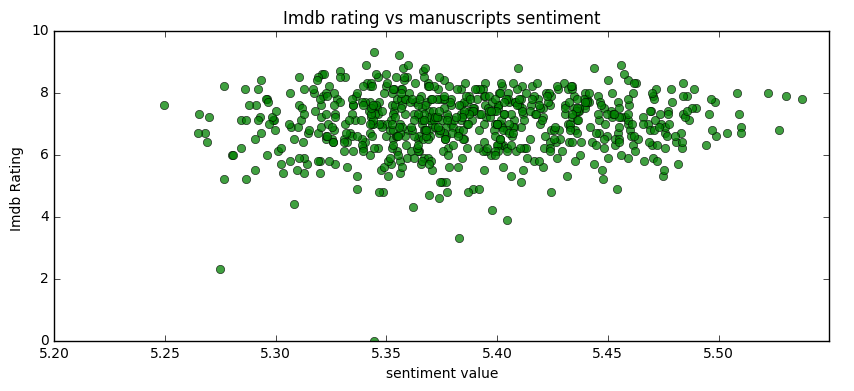

The correlation between the imdb rating and the sentiment is : 0.056641


In [441]:
movieRating_vs_sentiment = [(float(Imdb_5000_movies[key]),happiness_score) for key, happiness_score in happiness_score.items()
                           if Imdb_5000_movies[key] != None]
y,x =  zip(*movieRating_vs_sentiment)

plt.figure(figsize=(10,4))
plt.plot(x, y, 'o', color="green", alpha = 0.75)
plt.title("Imdb rating vs manuscripts sentiment")
plt.ylabel("Imdb Rating ")
plt.xlabel("sentiment value")
plt.show()


print("The correlation between the imdb rating and the sentiment is : {}".format(round_sig(np.corrcoef(x,y)[1][0],5)))

**TODO mögulega skoða bara top 10 highest ranked movies og bottom 10 lowest ranked movies and check if there is a correlation there with the sentiment **

** Revenue vs movie sentiment** 

Note: Some movies in the database do not have info about the revenue, Therefore the revenue is set to zero. We decided to exclude those movies from the analysis

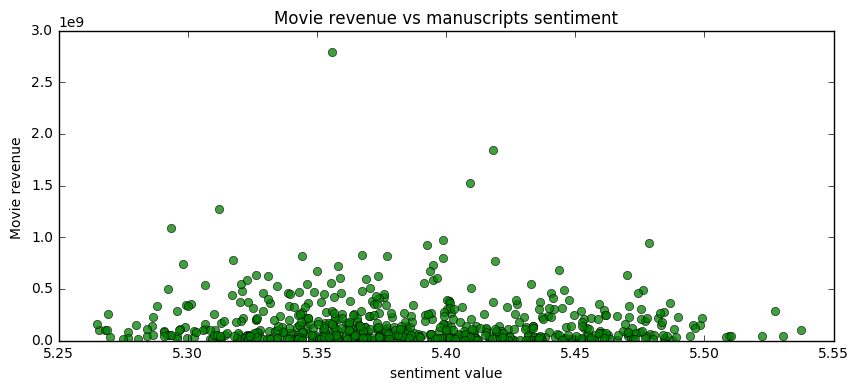

The correlation between the movie revenue and the sentiment is : -0.056532


In [442]:
movieGross_vs_sentiment = [(float(tmdb_5000_movies[key]['revenue']),happiness_score) for key, happiness_score in happiness_score.items()
                            if float(tmdb_5000_movies[key]['revenue']) != 0]

y,x =  zip(*movieGross_vs_sentiment)

plt.figure(figsize=(10,4))
plt.plot(x, y, 'o', color="green", alpha = 0.75)
plt.title("Movie revenue vs manuscripts sentiment")
plt.ylabel("Movie revenue ")
plt.xlabel("sentiment value")

plt.show()


print("The correlation between the movie revenue and the sentiment is : {}".format(round_sig(np.corrcoef(x,y)[1][0],5)))

## Sentiment per movie genre

We start the analysis by finding all the different genres of the movies. 

In [443]:
genres = set()

for key in happiness_score.keys():
    genres.update([genre['name'] for genre in tmdb_5000_movies[key]['genres']])

for genre in genres:
    print (genre)

Drama
Family
Thriller
Comedy
Animation
Romance
Fantasy
Horror
Adventure
Western
History
Music
Science Fiction
Action
Mystery
War
Crime


Next we want to visualize the average sentiment of the moviescripts for each genre. Each movie can have one or more genre. For this analysis we did not consider that to be a problem, we simply added the sentiment value for each moviescript into all of the genres that the movie is part of. Finally,we visualized the results in a boxplot.

In [444]:
# Find the average sentiment value for each genre

genre_dict = defaultdict(list)

# intialize the genre dictioary
for genre in genres:
    genre_dict[genre] = []
    
for key,value in happiness_score.items():
    # for each movie we add the sentimental value to all of the movies genres
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genre_dict[genre].append(value)

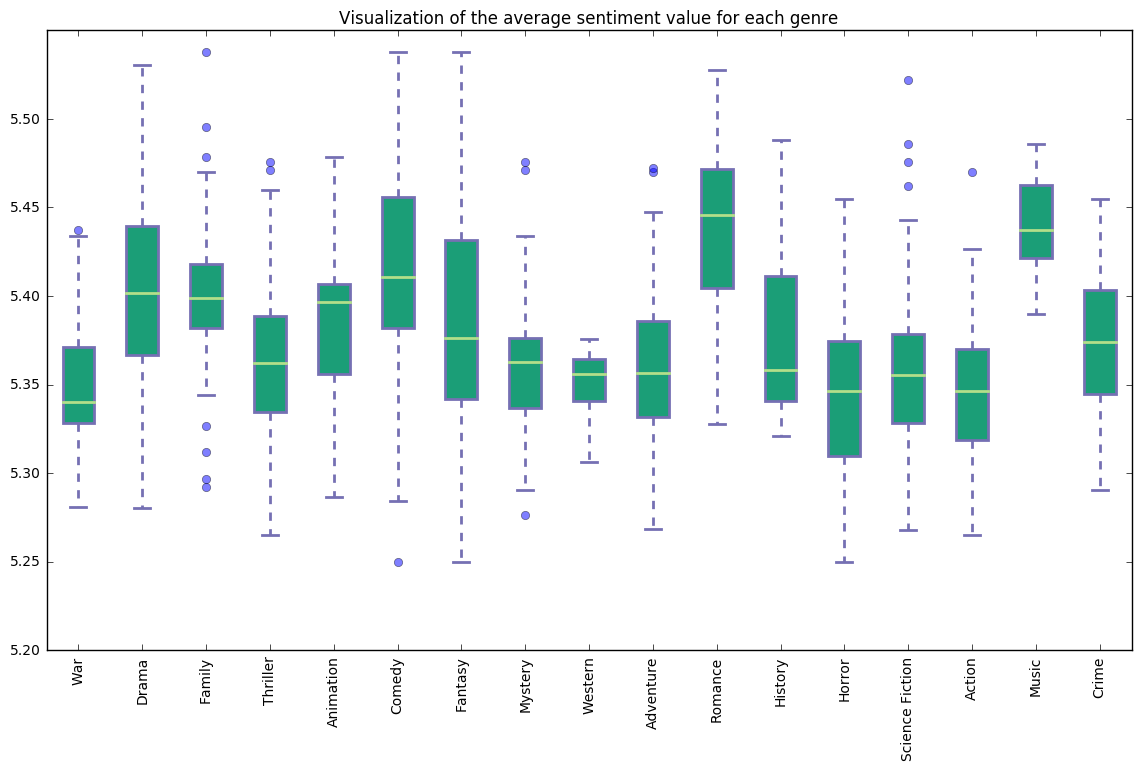

Genre                               Sentiment values 
----------------------------------------------------
Music                               5.4389         
Romance                             5.4372         
Comedy                              5.4154         
Drama                               5.4034         
Family                              5.4005         
Fantasy                             5.384          
Animation                           5.3836         
History                             5.3798         
Crime                               5.3724         
Thriller                            5.3623         
Mystery                             5.3599         
Adventure                           5.3581         
Science Fiction                     5.3558         
War                                 5.3512         
Western                             5.3491         
Action                              5.3452         
Horror                              5.344          


In [450]:
# Visualize the findings
# We will visualize the findings in a boxplot to be able to see the variance within each genre

x = [] # the genre name
y = [] # the sentiment values for the genres 

for key, values in genre_dict.items():
    x.append(key)
    y.append(values)

# Create a figure instance
fig = plt.figure(1, figsize=(14, 8))

# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(y, patch_artist=True)


## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

## Custom x-axis labels
ax.set_xticklabels(x,rotation = "vertical")

plt.title("Visualization of the average sentiment value for each genre")
    
plt.show()

# Finally we write out the average value for each genre

print ("{genres_s: <35} {value_s: <14} ".format(
    genres_s = "Genre", value_s = "Sentiment values"))

print("----------------------------------------------------")

genre_dict_mean = defaultdict(float)

# calculate the mean sentiment value for each genre
for key, values in genre_dict.items():
    genre_dict_mean[key] = np.mean(values)

for key, values in sorted(genre_dict_mean.items(),key=operator.itemgetter(1), reverse=True):
    print ("{genres_s: <35} {value_s: <14} ".format(
        genres_s = key , value_s = round_sig(np.mean(values),5)))
    
    
    
    

## Sentiment analysis of directors 

We are interested in seeing what directors are directing the happiest movies on average and what directors are directing the unhappiest movies on average. Because we have limited amount of manuscript we only considered directors that have directed more than 3 movies of the movies in our manuscript database. 

In [446]:
directors_happiness = defaultdict(list)

for key,value in happiness_score.items():
    director = [crew["name"] for crew in tmdb_5000_credits[key]['crew'] if crew["job"] == "Director"][0]
    directors_happiness[director].append(value)


In [447]:
directors_happiness_sorted = sorted([(directors, np.mean(values)) for directors,values in directors_happiness.items() if len(values) > 3], 
       key =  lambda x:x[1],
       reverse = True
    )

In [448]:
# print out top and bottom 10 directors of movies based on the happiness sentiment values of the movie's manuscripts

print("The 10 directors directing the movies with the HAPPIEST manuscripts on average \n")

print ("{director_s: <35} {sentimentscore_s: <16}".format(
    director_s = "Director", sentimentscore_s = "Avg. happyness score of manuscripts"))

print ("-----------------------------------------------------------------------")

for key,value in directors_happiness_sorted[0:10]:      
    print ("{director_s: <35} {sentimentscore_s: <16}".format(
            director_s =  key, 
            sentimentscore_s = round_sig(value,5)
        ))
    
    
print("\n\nThe 10 directors directing the movies with the UNHAPPIEST manuscripts on average \n")

print ("{director_s: <35} {sentimentscore_s: <16}".format(
    director_s = "Director", sentimentscore_s = "Avg. happyness score of manuscripts"))

print ("-----------------------------------------------------------------------")

for key,value in directors_happiness_sorted[-10:]:      
    print ("{director_s: <35} {sentimentscore_s: <16}".format(
            director_s =  key, 
            sentimentscore_s = round_sig(value,5)
        ))

The 10 directors directing the movies with the HAPPIEST manuscripts on average 

Director                            Avg. happyness score of manuscripts
-----------------------------------------------------------------------
Paul Thomas Anderson                5.4417          
Tim Burton                          5.4386          
Jonathan Demme                      5.4352          
Spike Lee                           5.4211          
Ang Lee                             5.4097          
Harold Ramis                        5.4001          
Robert Zemeckis                     5.3945          
Steven Soderbergh                   5.3922          
David O. Russell                    5.3907          
Martin Scorsese                     5.3905          


The 10 directors directing the movies with the UNHAPPIEST manuscripts on average 

Director                            Avg. happyness score of manuscripts
-----------------------------------------------------------------------
James Cameron   

**TODO túlka niðurstöður og mögulega gera boxplot**

## Term Frequency of the manuscripts, words that characterize the genres

Using the Term Frequency - Inverse Document Frequency, or TF-IDF, we can figure how important a word in a manuscript is for our total collection of scripts. So by doing this we can find the words that are most important for each genre of movies in our dataset. There are 17 different movie genres in our database, we will be focusing on the 6 genres that are associated with the highest numbers of manuscripts in our manuscripts database. 

### TF - IDF

**First**, check out the wikipedia page for [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Explain in your own words the point of TF-IDF.
    - What does TF stand for?
    - What does IDF stand for?
    
**Point of tf-idf** is to evaluate numerically how important a word is to a document in a collection or corpus. The ft-df value increases proportionally to the number of times a word appears in the document, but is often offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. 

tf-idf is the product of two statistics, term frequency and inverse document frequency. Note that there are various ways for determining the exect values of both statistics.

**Term frequency** tf(t,d), the simplest choice is to use the raw count of a term in a document, i.e. the number of times that term t occurs in document d. There are some other possibilities to evaluate the term frequency which can be found in the wikipedia page. 

** Inverse document frequency** is a measure of how much information the word provides, that is, whether the term is common or rare accross all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word, obtained by dividing the total number of documents by number of documents containing the term, and then taking the logarithm of that quotient. See [wikipage](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for detail about equaltion

### Word cloud

 - The package needs a string to work on. The way that I converted my TF-IDF results to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its TF-IDF score (rounded up to the nearest integer value).

 
### Procedure
The **procedure** can be described as follows
- First we find the movie genres that are associated with the highest number of manuscripts that we where able to gather
- Next we collect each manuscript that is a part of each genre. We then combine each genre´s manuscript into one huge text file. Therefore we will end up with 6 huge textfile, one for each genre that we are generating
- Next, we calculate the TF-IDF to figure out what words are important for each genre. We choose to use the TfidfVectorizer from sci kit learn module to implement the TF-IDF matrix for these 6 huge files. 
- Then we create a word cloud based on the TF-IDF matrix. 

**Works**

First we find the genres that are associated with the highest number of manuscripts that we where able to gather

In [459]:
genre_script_freq = defaultdict(int)
    
for key,value in happiness_score.items():
    # for each movie we add the sentimental value to all of the movies genres
    for genre in [genre['name'] for genre in tmdb_5000_movies[key]['genres']]:
        genre_script_freq[genre] += 1

all_genres = list(genre_script_freq.keys())       
        
genre_script_freq_top10,_ = zip(*sorted(genre_script_freq.items(),key=operator.itemgetter(1), reverse=True)[0:6])
print (genre_script_freq_top10)

('Drama', 'Thriller', 'Comedy', 'Action', 'Crime', 'Romance')


Now we have the genres that we want to analyse. The next thing to do is to get all of the movies that is associanted with each genre and create a huge file for each genre that contains all of the movie scripts associated with that genre. Note that some manuscripts have more than one genre so there will be small intersection between theses 11 huge files, we tried a couple of methods but this method revield the best result. We decided to create files for all genres but then we will only visualize the top 6 genres as a worldcloud :)

In [479]:
filepath_scripts =  "/Users/GretarAtli/Dropbox/SocialGraph/scripts/"
filepath_scripts_combined =  "/Users/GretarAtli/Dropbox/SocialGraph/scripts_combined/"

# create a dictionary that contains the combined text string for each genre
all_genres_scripts = defaultdict(str)

counter = 0
for title in sorted(manuscripts_intersection):
    title_for_uri = title.replace(" ","-").replace("(","").replace(")","")
    filename = filepath_scripts + title_for_uri + ".txt"
    #print (filename)
    f = open(filename,"r")

    movie_text_preprocessed = ""
    
    
    for line in f.readlines():
        
        # Clean the text by eliminating punctations 
        translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        line = line.translate(translator)
        
        # We decided to eliminate sentances if it only contains upper case letters. 
        # because we did not want to include the scene headings
        if not line.isupper():
            line = line.lower() # make the whole line lower case
            movie_text_preprocessed = movie_text_preprocessed + line
    
    #print (movie_text_preprocessed)
    
    # find the movie's genres 
    movie_genres = [genre for genre in [genre['name'] for genre in tmdb_5000_movies[title]['genres']]]
    
    # add the manuscript text to appropriate genre
    for genre in movie_genres:
        #print (genre)
        all_genres_scripts[genre] = all_genres_scripts[genre] + movie_text_preprocessed
    
    
    counter  = counter + 1
    

/Users/GretarAtli/Dropbox/SocialGraph/scripts/500-Days-of-Summer.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/10-Things-I-Hate-About-You.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/12-Years-a-Slave.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/127-Hours.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/15-Minutes.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/17-Again.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/2012.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/25th-Hour.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/30-Minutes-or-Less.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/42.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/8MM.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/9.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/A-Few-Good-Men.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/A-Most-Violent-Year.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/A-Nightmare-on-Elm-Street.txt
/Users/GretarAtli/Dropbox/SocialGraph/scripts/A-Serio

Everything is ready to do a TF_IDF analysis of the manuscripts for each genre. Like we mentioned here above, We decided to use the sci kit learn module to calculate the TF_IDF matrix. 

In [560]:
# get the text into a list of texts
branch_texts = []
for branch in all_genres_scripts.keys():
    branch_texts.append(all_genres_scripts[branch])


vectorizer = TfidfVectorizer(input = 'content', analyzer='word', min_df = 0, stop_words = 'english')
TF_IDF_matrix = vectorizer.fit_transform(branch_texts).todense()
features = vectorizer.get_feature_names()

Next we define a function that takes in a row of the tf-idf matrix. The  world cloud package needs a string to work on. Therefore for each line of the tf-idf matrix we convert the TF-IDF results to a string by simply combine all words together in one long string (separated by spaces), repeating each word according to its TF-IDF score (rounded up to the nearest integer value and multiplied with 10). The function does exactly that and returns the string. 

In [561]:
def getWordStringForGenre(TF_IDF_Vector):
    words = ""

    for i,tfidf_value in enumerate(np.array(TF_IDF_Vector)[0]):
        #print (i,math.ceil(tfidf_value))
        tfidf_value = math.ceil(tfidf_value*10)
        word = features[i] + " "
        words = words + tfidf_value * word
    return words

Go through each line of the TF_IDF matrix and create a wordcloud for each genre

Western


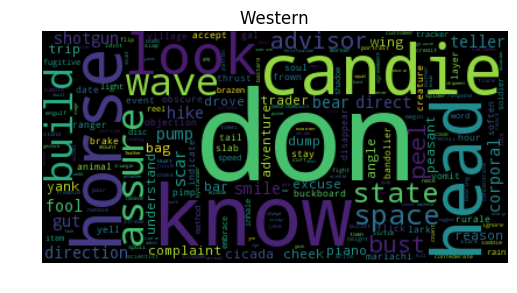

Drama


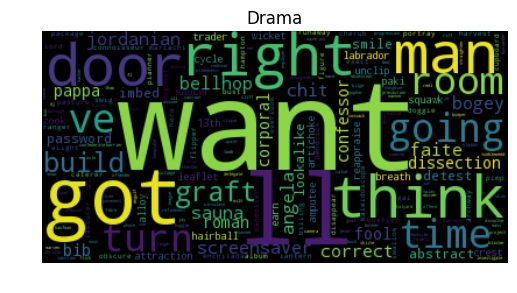

Family


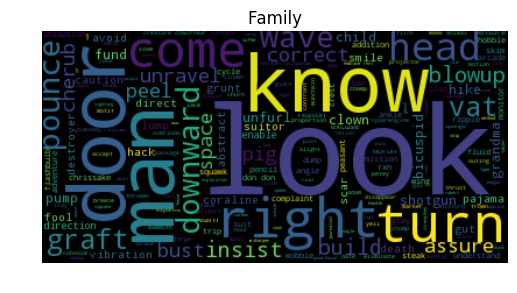

Thriller


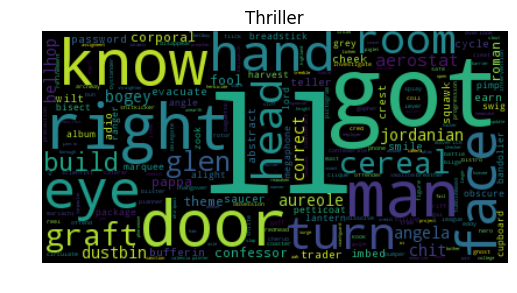

Mystery


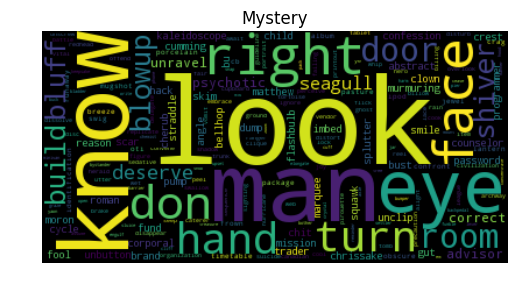

Comedy


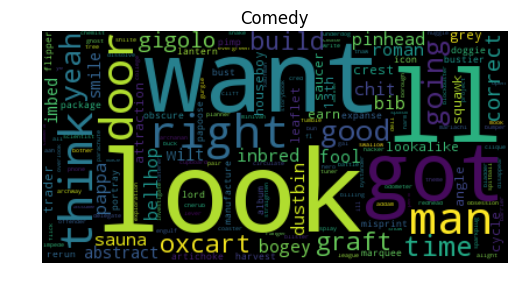

Romance


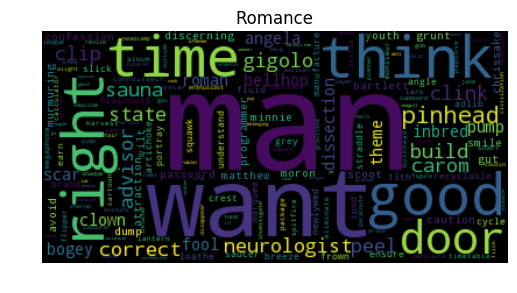

Horror


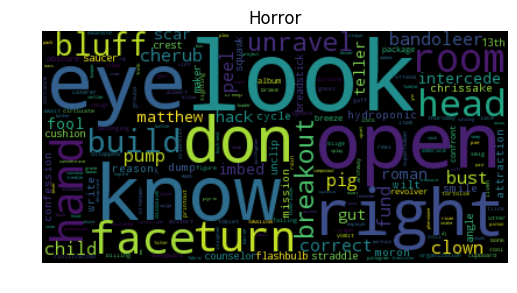

Adventure


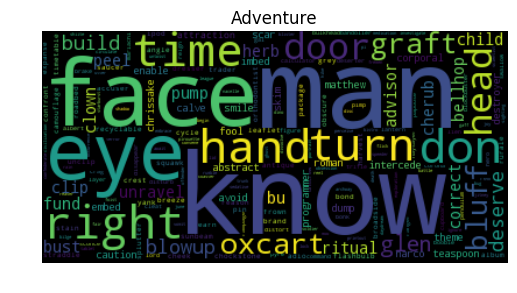

Fantasy


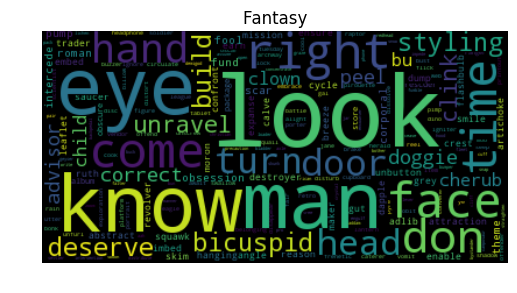

History


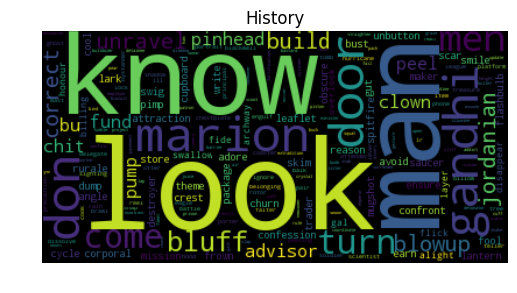

Music


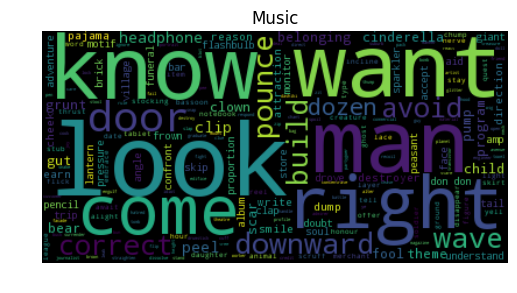

Science Fiction


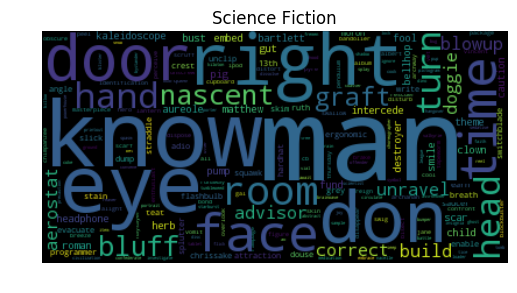

Action


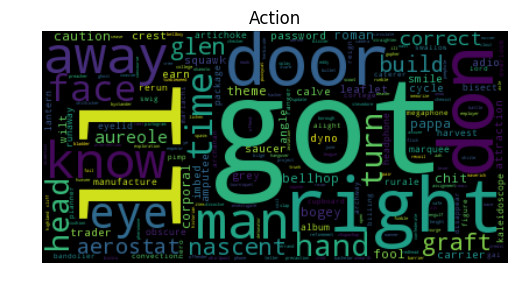

Animation


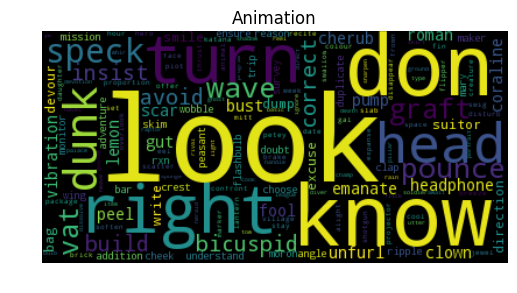

War


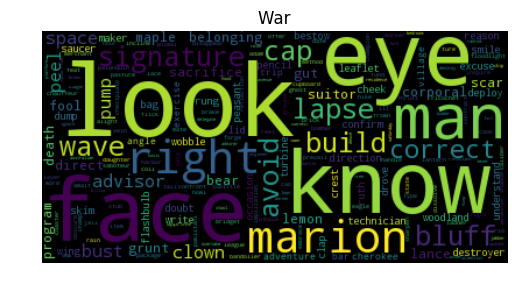

Crime


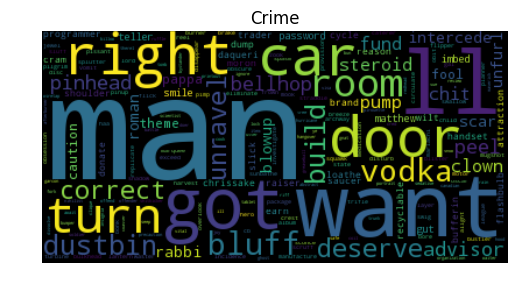

In [566]:
for i,row in enumerate(TF_IDF_matrix):
    
    genre = list(all_genres_scripts.keys())[i]
    print(genre)
    TF_IDF_string = getWordStringForGenre(row)
    wordcloud = WordCloud().generate(TF_IDF_string)
    img=plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(genre)
    plt.show()
    

In [522]:
np.array(TF_IDF_matrix[0])[0]

array([ 0.00052087,  0.00156261,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [555]:
bla = []

words = ""

for i,tfidf_value in enumerate(np.array(TF_IDF_matrix[0])[0]):
    #print (i,math.ceil(tfidf_value))
    tfidf_value = math.ceil(tfidf_value*10)
    word = features[i] + " "
    words = words + tfidf_value * word
    #bla.append(math.ceil(tfidf_value*100))


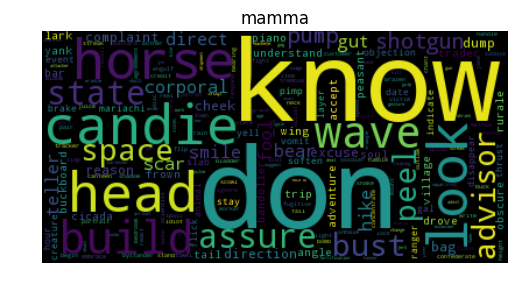

In [563]:
wordcloud = WordCloud().generate(words)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.title("mamma")
plt.show()

In [548]:

    for i,tfidf_value in enumerate(np.array(TF_IDF_matrix[0])[0]):
        #print (i,math.ceil(tfidf_value))
        tfidf_value = math.ceil(tfidf_value*10)
        word = features[i] + " "
        words = words + tfidf_value * word
    return words

'00 000 01 03 04 06 07 08 09 10 100 1000 101 102 103 104 105 106 107 108 109 109a 109b 109c 109d 109e 10x10 11 110 111 112 113 114 114a 114b 114c 115 115a 116 117 118 119 12 12 120 121 122 123 125 126 127 128 129 12th 13 1310 133 134 135 136 137 138 139 14 140 143 145 146 147 148 14k 15 150 151 152 154 1540 156 157 158 159 16 160 162 163 168 169 16l 17 171 172 176 177 1776 178 17l 17th 18 180 182 183 1835 185 186 1860 1879 189 18th 19 190 1908 191 1912 1913 1929 196 1968 197 198 1993 1998 19l 19th 1l 1ps 1st 20 200 2007 2009 202 203 208 20a 20b 20s 21 210 211 212 214 216 217 219 21a 22 220 225 226 227 228 229 229a 23 231 232 233 234 236 236c 236d 236dd 237 24 244 245 25 250 2500 252 253 255 256 259 26 263 266 268 269 27 275 279 28 283 284 286 288 29 290 295 296 29lï 2nd 30 300 301 307 308 309 31 311 312 314a 315 316 317 318 319 32 320 321 322 323 324 325 326 327 33 330 333 336 338 33a 33b 33c 34 342 343 345 346 347 347a 349 35 351 352 353 355 356 357 359 35l 36 360 361 363 365 366 367 

In [539]:
bla * 10

'mamma mamma mamma mamma mamma mamma mamma mamma mamma mamma '

Finally, we create the wordcloud for each genre

In [546]:
  
#text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."
#text = "Gretar Atli Gretarsson Gretar Atli Gretarsson Gretar Atli Gretarsson"

text = ""
for word,tfidf in tf_idfs[branch]["tf-idf"][:60]:
    text = text + int(round(tfidf))*word + " "
  
#or save as png
#img.write_png("wordcloud.png

NameError: name 'tf_idfs' is not defined

In [484]:
mamma = {
    "1":[1,2,3,4],
    "2":[5,6,7,8]
}

In [487]:
list(mamma.values())

[[1, 2, 3, 4], [5, 6, 7, 8]]